In [1]:
#Importing libraries

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import numpy as np

In [2]:
#Getting the filenames from train and test photos
from os import walk

filenames_train_broken = next(walk("images/train/broken"), (None, None, []))[2]  
filenames_train_intact = next(walk("images/train/intact"), (None, None, []))[2]

filenames_test_broken = next(walk("images/test/broken"), (None, None, []))[2]  
filenames_test_intact = next(walk("images/test/intact"), (None, None, []))[2]

In [3]:
# creating labels:
filenames_train_broken_labels = [0 for _ in filenames_train_broken]
filenames_train_intact_labels = [1 for _ in filenames_train_intact]

filenames_test_broken_labels = [0 for _ in filenames_test_broken]
filenames_test_intact_labels = [1 for _ in filenames_test_intact]

In [10]:
#  importing & reshaping images using openCV lib
from PIL import Image
import cv2 as cv
import matplotlib.pyplot as plt
data = []
labels = []

def importing_images(url, filenames, filenames_labels):
    global data, labels
    for name in filenames:
        img = cv.imread(url + name, cv.IMREAD_UNCHANGED)

        height, width = img.shape[:2]
        res = cv.resize(img,(224,224))

        res= res/255.
        data.append(res)

    labels = labels + [i for i in filenames_labels]
    

In [11]:
importing_images('./images/train/broken/', filenames_train_broken, filenames_train_broken_labels)
importing_images('./images/train/intact/', filenames_train_intact, filenames_train_intact_labels)
importing_images('./images/test/broken/', filenames_test_broken, filenames_test_broken_labels)
importing_images('./images/test/intact/',filenames_test_intact, filenames_test_intact_labels)

In [12]:
print(len(data), len(labels))

170 170


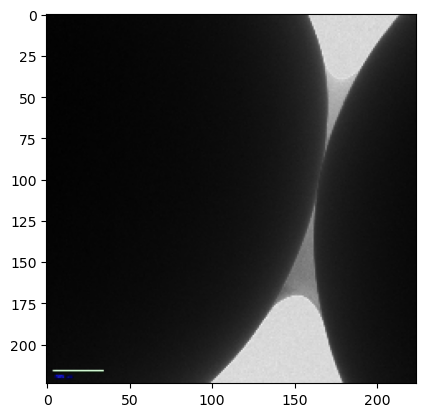

In [14]:
# plotting a random image from data list
index = np.random.randint(0, len(data))
sample = data[index]
plt.imshow(sample)
plt.show()

# Model is made used Transfer Learning feature extraction

In [16]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
     

In [17]:
#use transfer learning: feature extraction
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"


In [22]:
def create_model(model_url, num_classes=1):
    # Download the pretrained model and save it as a Keras layer
    feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=(224,224,3)) # define the input image shape
  
    # Create our own model
    model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(1, activation='sigmoid', name='output_layer') # create our own output layer      
  ])

    return model

In [23]:
# turning list to np arrays
data = np.array(data)
labels = np.array(labels)

In [115]:
print(labels)

[1 1 1 0 0 0 0 1 0 0 1 1 0 1 1 1 1 0 0 0 0 1 0 1 1 1 1 0 1 1 1 1 1 0 0 1 1
 0 1 1 1 1 1 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 0 0 0 0 0 1 1 1
 1 1 1 0 0 1 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 0 1 1 1 1 1 0
 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 0 1 1 1 0 1 0 1 1 1 1 0 1 1 1
 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 0 1 0]


In [24]:
# shuffling the data
r_indexes = np.arange(len(data))
np.random.shuffle(r_indexes)
data= data[r_indexes]
labels = labels[r_indexes]

# Implementing cross-validation

In [26]:
from sklearn.model_selection import StratifiedKFold

In [27]:
skf = StratifiedKFold(n_splits=5)
fold_no = 1
acc_per_fold, loss_per_fold = [], []

In [28]:
for i, (train_index, test_index) in enumerate(skf.split(data, labels)):
    X = tf.data.Dataset.from_tensor_slices((tf.constant(data[train_index]), tf.constant(labels[train_index])))
    #X = X.shuffle(buffer_size=len(X))
    X_batch = X.batch(32)
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)

    model = create_model(efficientnet_url, num_classes=1)
    model.compile(loss='binary_crossentropy',
                         optimizer=opt,
                         metrics=['accuracy'])
    model.fit(x=X_batch,
            epochs=10)
    
    X_test = tf.data.Dataset.from_tensor_slices((tf.constant(data[test_index]), tf.constant(labels[test_index])))
    X_test_batch = X_test.batch(32)

        
    scores = model.evaluate(X_test_batch)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    fold_no = fold_no + 1

    

Epoch 1/10
5/5 [==============================] - 17s 477ms/step - loss: 0.7196 - accuracy: 0.5221
Epoch 2/10
5/5 [==============================] - 2s 364ms/step - loss: 0.6223 - accuracy: 0.6397
Epoch 3/10
5/5 [==============================] - 2s 363ms/step - loss: 0.5578 - accuracy: 0.6397
Epoch 4/10
5/5 [==============================] - 2s 452ms/step - loss: 0.4959 - accuracy: 0.7279
Epoch 5/10
5/5 [==============================] - 2s 452ms/step - loss: 0.4458 - accuracy: 0.8162
Epoch 6/10
5/5 [==============================] - 2s 427ms/step - loss: 0.4052 - accuracy: 0.8529
Epoch 7/10
5/5 [==============================] - 2s 415ms/step - loss: 0.3701 - accuracy: 0.8603
Epoch 8/10
5/5 [==============================] - 2s 400ms/step - loss: 0.3408 - accuracy: 0.8676
Epoch 9/10
5/5 [==============================] - 2s 382ms/step - loss: 0.3164 - accuracy: 0.8676
Epoch 10/10
2/2 [==============================] - 2s 103ms/step - loss: 0.2826 - accuracy: 0.8824
Score for fold 1: 

2/2 [==============================] - 2s 121ms/step - loss: 0.2823 - accuracy: 0.9412
Score for fold 5: loss of 0.28229373693466187; accuracy of 94.11764740943909%


In [29]:
acc_per_fold, loss_per_fold 
print(f"average accuracy is: {sum(acc_per_fold)/len(acc_per_fold)} and average loss is: {sum(loss_per_fold)/len(loss_per_fold)}")

average accuracy is: 92.35294103622437 and average loss is: 0.2820234656333923
